In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class Dense:
    def __init__(self, units, input_size, activation, name):
        self.W = tf.Variable(tf.random.normal([units, input_size]) * tf.math.sqrt(1/input_size), name=(name + '_W'))
        self.b = tf.Variable(tf.zeros([units,1]), name=(name + '_b'))
        self.activation = activation

    def forward(self, X, training):
        Z = tf.linalg.matmul(self.W,X) + self.b
        A = self.activation(Z)
        return A

    def get_vars(self):
        return [self.W, self.b]

In [3]:
class Batch_norm:
    def __init__(self, units, input_size, activation, name):
        self.W = tf.Variable(tf.random.normal([units, input_size]) * tf.math.sqrt(1/input_size), name=(name + '_W')) 
        self.activation = activation

        self.gamma = tf.Variable(tf.ones([units, 1]), name=(name + '_gamma'))
        self.beta = tf.Variable(tf.ones([units, 1]), name=(name + '_beta'))
        self.mu_test = tf.Variable(tf.zeros([units,1]))
        self.sigma_test = tf.Variable(tf.ones([units,1]))

    def forward(self, X, training):
        e = 10**-8

        Z = tf.linalg.matmul(self.W,X)

        if training:
            mu = tf.math.reduce_mean(Z, axis=1, keepdims=True)
            sigma = tf.math.reduce_variance(Z - mu, axis=1, keepdims=True)
            sigma = tf.math.sqrt(sigma + e)

            self.mu_test.assign(0.95*self.mu_test + 0.05*mu)
            self.sigma_test.assign(0.95*self.sigma_test + 0.05*sigma)
        else:
            mu = self.mu_test
            sigma = self.sigma_test

        Z = (Z - mu) / sigma
        Z = self.gamma * Z + self.beta

        A = self.activation(Z)
        return A

    def get_vars(self):
        return [self.W, self.gamma, self.beta]

In [4]:
class Dropout:
    def __init__(self, keep_prob):
        self.keep_prob = keep_prob

    def forward(self, X, training):
        if not training:
            return X
        X = tf.nn.dropout(X, 1-self.keep_prob)
        # D = tf.random.uniform(tf.shape(X)) < self.keep_prob
        # D = tf.cast(D, dtype=tf.float32)
        # X = X * D
        # X = X / self.keep_prob
        return X

    def get_vars(self):
        return None

In [5]:
class Softmax:
    def __init__(self, classes, input_size, name):
        self.classes = classes

        self.W = tf.Variable(tf.random.normal([classes, input_size]) * tf.math.sqrt(1/input_size), name=(name + '_W'))
        self.b = tf.Variable(tf.zeros([classes,1]), name=(name + '_b'))

    def forward(self, X, training):
        Z = tf.linalg.matmul(self.W,X) + self.b

        T = tf.math.exp(Z)
        A = T / tf.math.reduce_sum(T, axis=0)
        return A

    def get_vars(self):
        return [self.W, self.b]

In [39]:
class Adam:
    def __init__(self):
        self.v = []
        self.s = []
        self.iteration = 0

    def update_params(self, params, grads, learning_rate, beta_v = 0.9, beta_s = 0.999):
        self.iteration += 1
        for i in range(len(grads)):
            if len(self.v) <= i:
                self.v.append(tf.Variable(tf.zeros(tf.shape(grads[i]))))
            if len(self.s) <= i:
                self.s.append(tf.Variable(tf.zeros(tf.shape(grads[i]))))
            self.v[i].assign(beta_v*self.v[i] + (1-beta_v)*grads[i])
            v_corrected = self.v[i] / (1 - tf.math.pow(beta_v,self.iteration))

            self.s[i].assign(beta_s*self.s[i] + (1-beta_s)* tf.math.square(grads[i]))
            s_corrected = self.s[i] / (1 - tf.math.pow(beta_s,self.iteration))

            change = learning_rate * (v_corrected/(tf.math.sqrt(s_corrected) + 10**-8))
            params[i].assign_add(-change)

In [7]:
def Loss(A, Y):
    loss = tf.math.log(A)
    loss = Y * loss
    loss = -tf.math.reduce_sum(loss, axis=0)
    return loss

In [8]:
def Cost(A, Y):
    losses = Loss(A, Y)
    cost = tf.reduce_mean(losses)
    return cost

In [9]:
def forward_pass(X, layers, training):
    for layer in layers:
        X = layer.forward(X, training)
    return X

In [10]:
def get_vars(layers):
    var = []
    for layer in layers:
        x = layer.get_vars()
        if x != None:
            var += x
    return var

In [11]:
def create_layers():
    layers = []
    i = 1
    for layer_name in layer_names:
        if layer_name == 'dense':
            layer = Dense(hidden_units[i], hidden_units[i-1], tf.nn.sigmoid, 'Dense' + str(i+1))
            layers.append(layer)
            i += 1

        elif layer_name == 'batch_norm':
            layer = Batch_norm(hidden_units[i], hidden_units[i-1], tf.nn.sigmoid, 'Batch_norm' + str(i+1))
            layers.append(layer)
            i += 1

        elif layer_name == 'dropout':
            layer = Dropout(keep_prob)
            layers.append(layer)

        elif layer_name == 'softmax':  
            layer = Softmax(hidden_units[i], hidden_units[i-1], 'Dense' + str(i+1))
            layers.append(layer)
            i += 1

    return layers

In [12]:
def create_batches(data, batch_size):
    mini_batches = []
    n = int(data.shape[1] / batch_size)
    for i in range(n):
        mini_batches.append(data[:,i*batch_size:(i+1)*batch_size])
    mini_batches.append(data[:,-(data.shape[1] % batch_size):])
    return mini_batches

In [32]:
def training_step_template(X_train_batches, Y_train_batches, X_test, Y_test, layers, optymizer, learning_rate):
    n = X_train_batches.shape[0]
    cost_train = 0
    for i in range(n):
        X = X_train_batches[i].to_tensor()
        Y = Y_train_batches[i].to_tensor()
        with tf.GradientTape() as tape:
            params = get_vars(layers)
            tape.watch(params)
            A = forward_pass(X, layers, training=True)
            cost = Cost(A, Y)
            cost_train = (cost_train * i + cost) / (i+1)
        grads = tape.gradient(cost, params)
        optymizer.update_params(params, grads, learning_rate)
    A_test = forward_pass(X_test, layers, False)
    cost_test = Cost(A_test, Y_test)
    cost_train = tf.math.reduce_mean(cost_train)
    return (cost_train, cost_test)

In [20]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train / 255
x_test = x_test / 255
y_train = tf.one_hot(y_train, depth=10, axis=0)
y_test = tf.one_hot(y_test, depth=10, axis=0)

x_train = tf.reshape(x_train, [784, -1])
x_train = tf.cast(x_train, tf.float32)

x_test = tf.reshape(x_test, [784, -1])
x_test = tf.cast(x_test, tf.float32)

x_train = x_test[:,:10000].numpy()
y_train = y_train[:,:10000].numpy()

x_test = x_test[:,:1000]
y_test = y_test[:,:1000]


x_train_batches = create_batches(x_train, batch_size)
y_train_batches = create_batches(y_train, batch_size)

x_train_batches = tf.ragged.constant(x_train_batches)
y_train_batches = tf.ragged.constant(y_train_batches)

In [15]:
layer_names = ['dense', 'batch_norm', 'dense', 'softmax']
hidden_units = [16,8,8,10]
input_size = 784
hidden_units.insert(0, input_size)

learning_rate = tf.constant(0.001, dtype=tf.float32)
keep_prob = 0.9

image_height = 28
image_width = 28

m_train = x_train.shape[1]
m_test = x_test.shape[1]

batch_size = 256

In [40]:
layers = create_layers()
costs = []
optimizer = Adam()

training_step = tf.function(training_step_template)

Epoch 0.0: (<tf.Tensor: shape=(), dtype=float32, numpy=2.3838956>, <tf.Tensor: shape=(), dtype=float32, numpy=2.4151578>)
Epoch 100.0: (<tf.Tensor: shape=(), dtype=float32, numpy=2.3835862>, <tf.Tensor: shape=(), dtype=float32, numpy=2.4141715>)
Epoch 200.0: (<tf.Tensor: shape=(), dtype=float32, numpy=2.3835862>, <tf.Tensor: shape=(), dtype=float32, numpy=2.4141715>)
Epoch 300.0: (<tf.Tensor: shape=(), dtype=float32, numpy=2.3835862>, <tf.Tensor: shape=(), dtype=float32, numpy=2.4141715>)
Epoch 400.0: (<tf.Tensor: shape=(), dtype=float32, numpy=2.3835862>, <tf.Tensor: shape=(), dtype=float32, numpy=2.4141715>)
Epoch 500.0: (<tf.Tensor: shape=(), dtype=float32, numpy=2.3835862>, <tf.Tensor: shape=(), dtype=float32, numpy=2.4141715>)
Epoch 600.0: (<tf.Tensor: shape=(), dtype=float32, numpy=2.3835862>, <tf.Tensor: shape=(), dtype=float32, numpy=2.4141715>)
Epoch 700.0: (<tf.Tensor: shape=(), dtype=float32, numpy=2.3835862>, <tf.Tensor: shape=(), dtype=float32, numpy=2.4141715>)
Epoch 800.

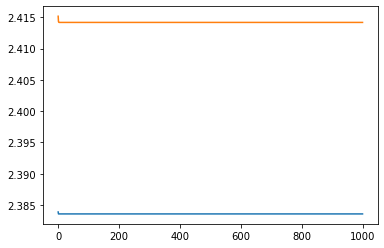

In [41]:
for i in tf.range(1000, dtype=tf.float32):
    cost = training_step(x_train_batches, y_train_batches, x_test, y_test, layers, optimizer, learning_rate)
    costs.append(cost)
    if i%100 == 0:
        print('Epoch {0}: {1}'.format(i, cost))

plt.plot(costs)
plt.show()

In [35]:
prediction = forward_pass(x_train, layers, False)
a = tf.argmax(prediction, axis=0)
y = tf.argmax(y_train, axis=0)

b = a==y
b = tf.cast(b, tf.float32)
b = tf.reduce_sum(b)
print(b/10000)

tf.Tensor(0.4098, shape=(), dtype=float32)
